# Setup

In [12]:
%matplotlib inline

In [13]:
# Library imports
from fastai.vision.all import *
from nbdev.showdoc import *
# from zipfile import ZipFile

set_seed(42) # for reproducible random numbers

In [14]:
# Change this to another device (0-7) if you run out of memory
# Goto Kernel->Restart&Clear Output after changing the device
torch.cuda.set_device(1)

In [15]:
# Batch size: https://docs.paperspace.com/machine-learning/wiki/epoch
# Typically 32 works fine, feel free to experiment with it
# If you run out of memory, try to lower the number
bs = 32

# Get Data

We'll use the MNIST Dataset (http://yann.lecun.com/exdb/mnist/) and try to predict handwritten digits.

Here's a list of available datasets: https://docs.fast.ai/data.external.html

In [16]:
path = 'competition_group2/group2_dataset'

In [17]:

# with ZipFile('competition_group2.zip', 'r') as archive:
#     archive.extractall('/home/ele_group_2/ml/')

In [18]:
fns=get_image_files(path)
fns

(#901) [Path('competition_group2/group2_dataset/091.jpg'),Path('competition_group2/group2_dataset/753.jpg'),Path('competition_group2/group2_dataset/495.jpg'),Path('competition_group2/group2_dataset/284.jpg'),Path('competition_group2/group2_dataset/463.jpg'),Path('competition_group2/group2_dataset/468.jpg'),Path('competition_group2/group2_dataset/083.jpg'),Path('competition_group2/group2_dataset/489.jpg'),Path('competition_group2/group2_dataset/089.jpg'),Path('competition_group2/group2_dataset/748.jpg')...]

In [19]:
df = pd.read_csv('competition_group2/labels_group2_test.csv',  dtype=str , sep=';')

In [20]:
df.head()

id             label
0  000             wheat
1  001  common_chickweed
2  002  common_chickweed
3  003  common_chickweed
4  004  common_chickweed

# Step 1 - Data Loader

In [21]:
dls = ImageDataLoaders.from_df(df, path,suff='.jpg',item_tfms=Resize(300),valid_pct=(0.2),seed=42)

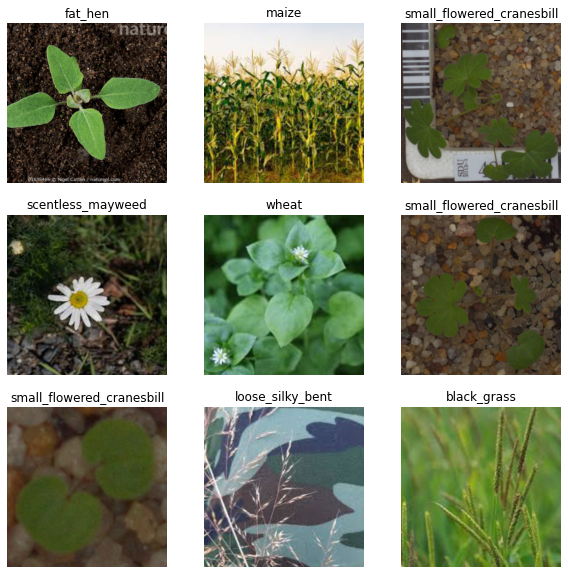

In [22]:
dls.show_batch(max_n=9, figsize=(10,10))

In [23]:
learner = cnn_learner(dls, resnet50, metrics=[accuracy, error_rate])

/home/ele_group_2/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/home/ele_group_2/miniconda3/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0003311311302240938)

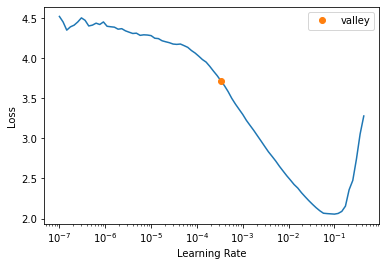

In [24]:
learner.lr_find()

In [25]:
learner.fit_one_cycle(10)

In [26]:
learner.fine_tune(5, 0.0003)

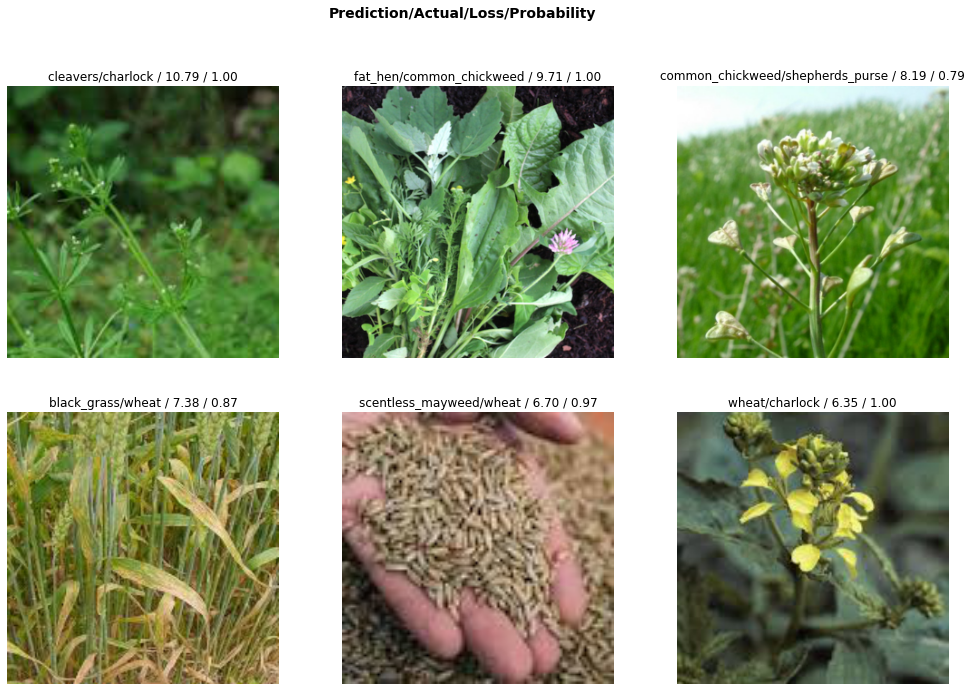

In [27]:
interpretation = ClassificationInterpretation.from_learner(learner)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(6, figsize=(17,11))

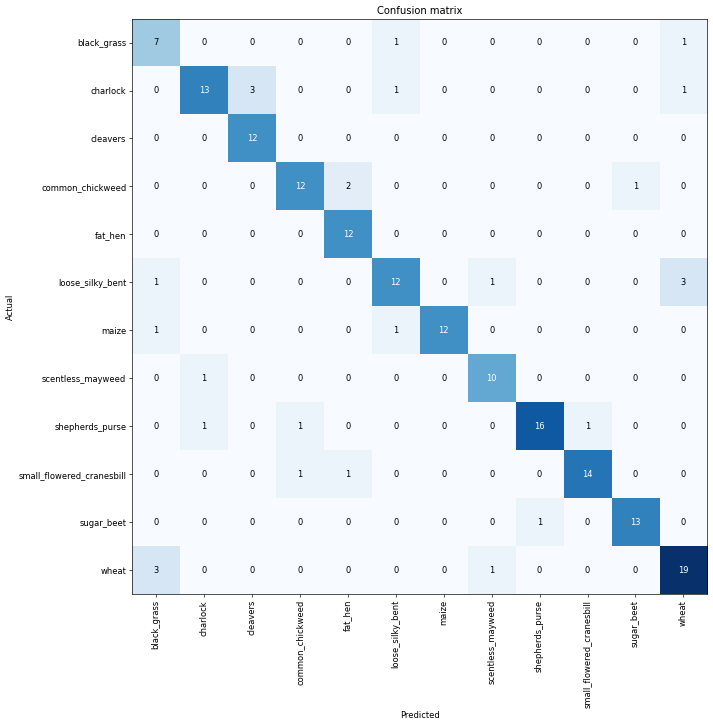

In [28]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

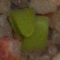

In [29]:
image_path = 'plant_seedlings_v2/sugar_beet/1.png'
img=load_image(image_path)
img

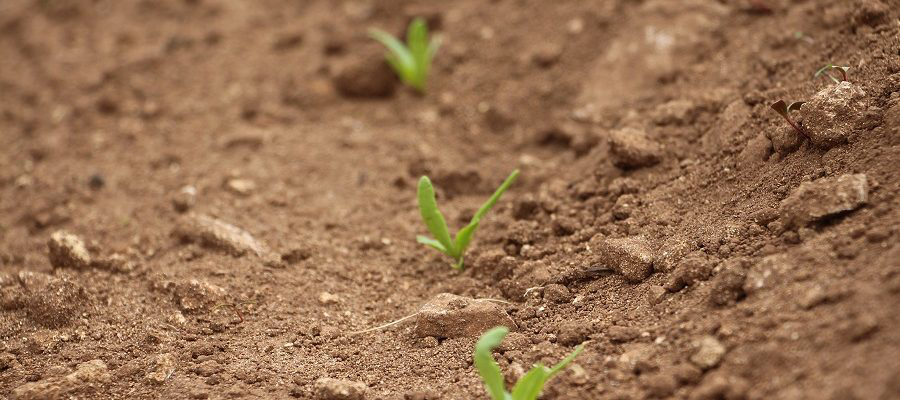

In [30]:
image_path1 = 'competition_group2/group2_dataset/048.jpg'
img1=load_image(image_path1)
img1

In [31]:
label,_,probs = learner.predict(image_path)
print(label.split('/')[-1])
print(max(probs))

shepherds_purse
tensor(0.9982)


# Step 3 - Learning

In [32]:
learner.fit_one_cycle(3)

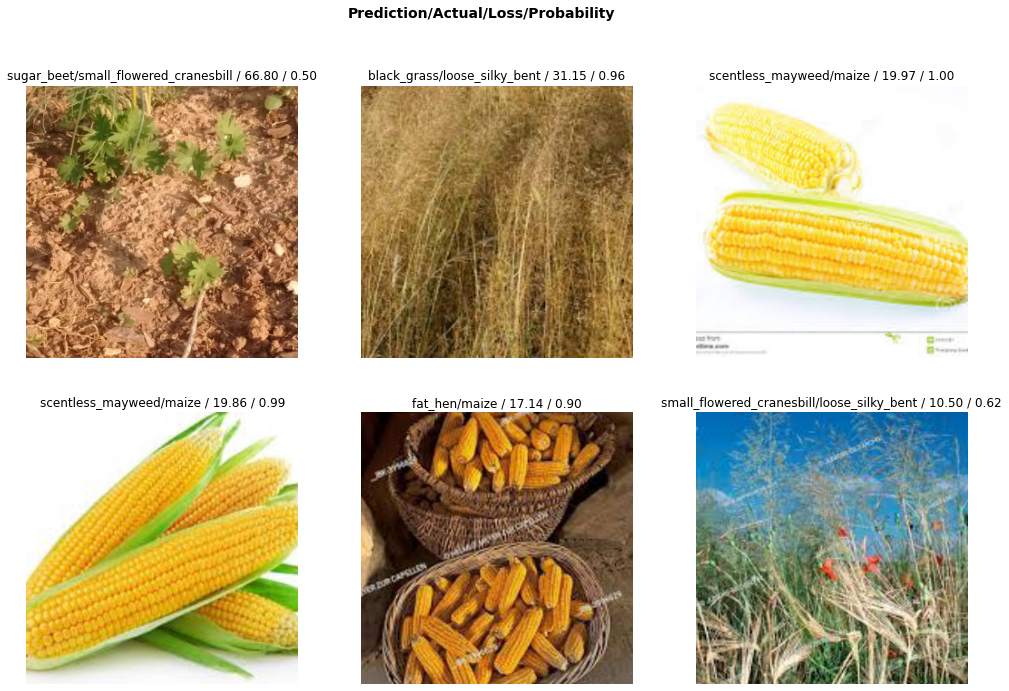

In [33]:
interpretation = ClassificationInterpretation.from_learner(learner)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(6, figsize=(17,11))

In [34]:
learner.save('stage-1_0.08')

Path('competition_group2/group2_dataset/models/stage-1_0.08.pth')

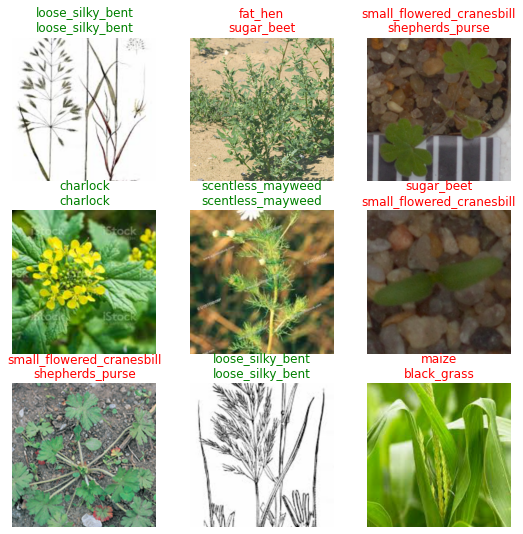

In [35]:
learner.show_results()

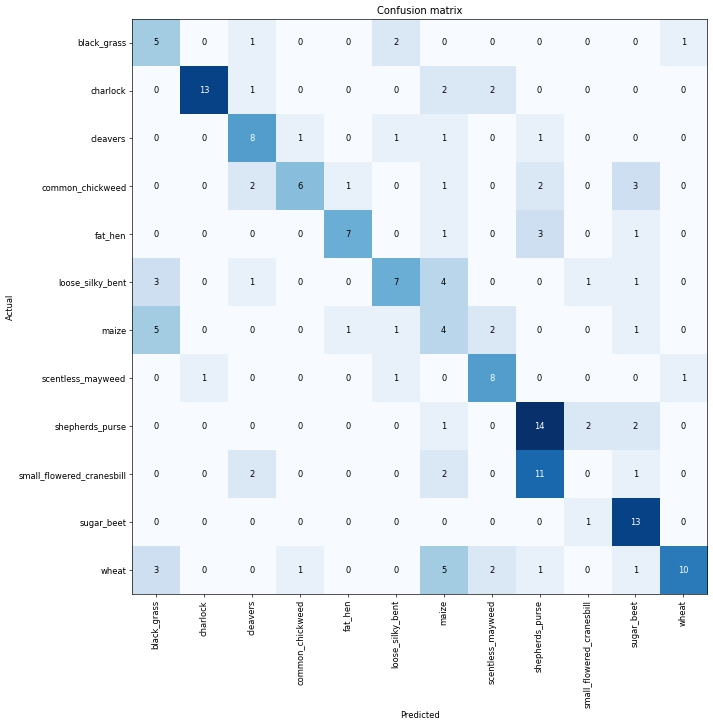

In [36]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Optimization

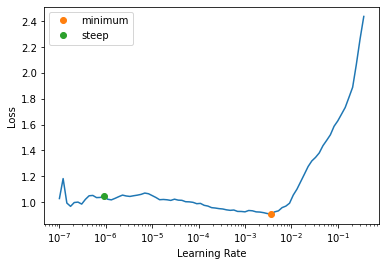

In [37]:
lr_min,lr_steep = learner.lr_find(suggest_funcs=(minimum,steep))

In [38]:
interpretation.most_confused(min_val=2)

[('small_flowered_cranesbill', 'shepherds_purse', 11),
 ('maize', 'black_grass', 5),
 ('wheat', 'maize', 5),
 ('loose_silky_bent', 'maize', 4),
 ('common_chickweed', 'sugar_beet', 3),
 ('fat_hen', 'shepherds_purse', 3),
 ('loose_silky_bent', 'black_grass', 3),
 ('wheat', 'black_grass', 3),
 ('black_grass', 'loose_silky_bent', 2),
 ('charlock', 'maize', 2),
 ('charlock', 'scentless_mayweed', 2),
 ('common_chickweed', 'cleavers', 2),
 ('common_chickweed', 'shepherds_purse', 2),
 ('maize', 'scentless_mayweed', 2),
 ('shepherds_purse', 'small_flowered_cranesbill', 2),
 ('shepherds_purse', 'sugar_beet', 2),
 ('small_flowered_cranesbill', 'cleavers', 2),
 ('small_flowered_cranesbill', 'maize', 2),
 ('wheat', 'scentless_mayweed', 2)]

In [39]:
learner = cnn_learner(dls, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0006918309954926372)

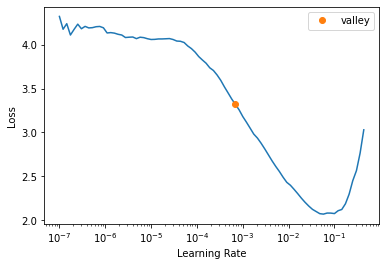

In [40]:
learner.lr_find()

In [41]:
learner.fit_one_cycle(3, lr_max=0.0014)

In [42]:
learner.fine_tune(3, 3e-2)

In [43]:
learner.save('stage-2_0.06')

Path('competition_group2/group2_dataset/models/stage-2_0.06.pth')

In [44]:
print("Accuracy: ", 1-float(learner.recorder.metrics[0].value))

Accuracy:  0.7166666686534882


# Resnet 152

In [45]:
learner = cnn_learner(dls, resnet152, metrics=error_rate)

In [46]:
learner.fit_one_cycle(10)

RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 1; 39.59 GiB total capacity; 14.26 GiB already allocated; 23.81 MiB free; 14.48 GiB reserved in total by PyTorch)

In [ ]:
learner.fine_tune(10, 3e-2)

In [47]:
print("Accuracy: ", 1-float(learner.recorder.metrics[0].value))

AttributeError: 'AvgMetric' object has no attribute 'count'

In [48]:
learner.save('stage-3_0.04')

Path('competition_group2/group2_dataset/models/stage-3_0.04.pth')

In [49]:
interpretation = ClassificationInterpretation.from_learner(learner)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(6, figsize=(17,11))

RuntimeError: CUDA out of memory. Tried to allocate 66.00 MiB (GPU 1; 39.59 GiB total capacity; 14.26 GiB already allocated; 23.81 MiB free; 14.48 GiB reserved in total by PyTorch)

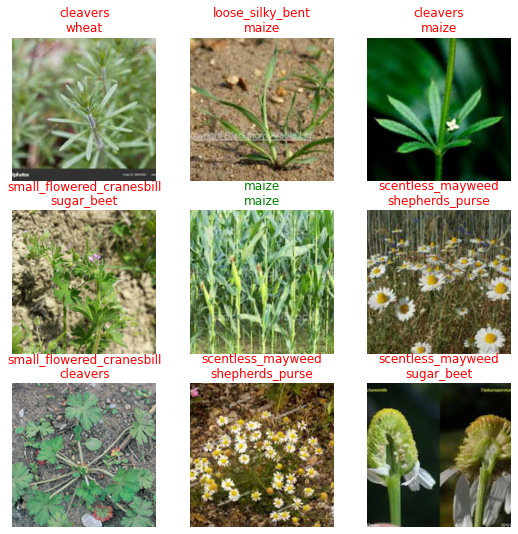

In [50]:
learner.show_results()

In [51]:
lr_min,lr_steep = learner.lr_find(suggest_funcs=(minimum,steep))

RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 1; 39.59 GiB total capacity; 14.23 GiB already allocated; 23.81 MiB free; 14.48 GiB reserved in total by PyTorch)

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(3, lr_max=slice(9.12e-8,9.12e-7))

In [52]:
lr_steep

9.12010818865383e-07

In [53]:
interpretation.most_confused(min_val=2)

[('small_flowered_cranesbill', 'shepherds_purse', 11),
 ('maize', 'black_grass', 5),
 ('wheat', 'maize', 5),
 ('loose_silky_bent', 'maize', 4),
 ('common_chickweed', 'sugar_beet', 3),
 ('fat_hen', 'shepherds_purse', 3),
 ('loose_silky_bent', 'black_grass', 3),
 ('wheat', 'black_grass', 3),
 ('black_grass', 'loose_silky_bent', 2),
 ('charlock', 'maize', 2),
 ('charlock', 'scentless_mayweed', 2),
 ('common_chickweed', 'cleavers', 2),
 ('common_chickweed', 'shepherds_purse', 2),
 ('maize', 'scentless_mayweed', 2),
 ('shepherds_purse', 'small_flowered_cranesbill', 2),
 ('shepherds_purse', 'sugar_beet', 2),
 ('small_flowered_cranesbill', 'cleavers', 2),
 ('small_flowered_cranesbill', 'maize', 2),
 ('wheat', 'scentless_mayweed', 2)]

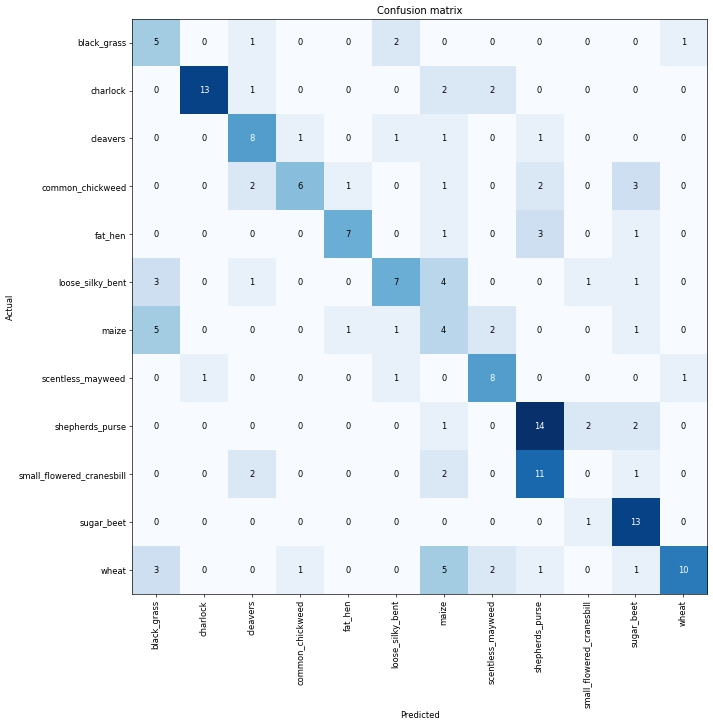

In [54]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)